In [2]:
import pandas as pd 
import numpy as np 

In [3]:
df = pd.read_json('roam_prescription_based_prediction.jsonl' , lines=True)
df.head()

,cms_prescription_counts,provider_variables,npi
0,"{'DOXAZOSIN MESYLATE': 26, 'MIDODRINE HCL': 12...","{'settlement_type': 'non-urban', 'generic_rx_c...",1295763035
1,"{'CEPHALEXIN': 23, 'AMOXICILLIN': 52, 'HYDROCO...","{'settlement_type': 'non-urban', 'generic_rx_c...",1992715205
2,"{'CEPHALEXIN': 28, 'AMOXICILLIN': 73, 'CLINDAM...","{'settlement_type': 'non-urban', 'generic_rx_c...",1578587630
3,{'AMOXICILLIN': 63},"{'settlement_type': 'non-urban', 'generic_rx_c...",1932278405
4,"{'PIOGLITAZONE HCL': 24, 'BENAZEPRIL HCL': 29,...","{'settlement_type': 'non-urban', 'generic_rx_c...",1437366804


In [4]:
# Need to calculate product Rx and Market Rx
# Identified our product as PREDNISONE
# Market drugs as METOLAZONE,OMEPRAZOLE,LISINOPRIL
def get_prednisone_rx(drug_dct):
    if('PREDNISONE' in list(drug_dct.keys())):
        return drug_dct['PREDNISONE']
    else:
        return 0

def get_market_rx(drug_dct):
    total_rx = 0
    if('PREDNISONE' in list(drug_dct.keys())):
        total_rx += drug_dct['PREDNISONE']
    if('METOLAZONE' in list(drug_dct.keys())):
        total_rx += drug_dct['METOLAZONE']
    if('OMEPRAZOLE' in list(drug_dct.keys())):
        total_rx += drug_dct['OMEPRAZOLE']
    if('LISINOPRIL' in list(drug_dct.keys())):
        total_rx += drug_dct['LISINOPRIL']
    return total_rx

In [5]:
df['prednisone_rx'] = df['cms_prescription_counts'].apply(get_prednisone_rx)
df['market_rx'] = df['cms_prescription_counts'].apply(get_market_rx)

In [6]:
df.head()

,cms_prescription_counts,provider_variables,npi,prednisone_rx,market_rx
0,"{'DOXAZOSIN MESYLATE': 26, 'MIDODRINE HCL': 12...","{'settlement_type': 'non-urban', 'generic_rx_c...",1295763035,40,192
1,"{'CEPHALEXIN': 23, 'AMOXICILLIN': 52, 'HYDROCO...","{'settlement_type': 'non-urban', 'generic_rx_c...",1992715205,0,0
2,"{'CEPHALEXIN': 28, 'AMOXICILLIN': 73, 'CLINDAM...","{'settlement_type': 'non-urban', 'generic_rx_c...",1578587630,0,0
3,{'AMOXICILLIN': 63},"{'settlement_type': 'non-urban', 'generic_rx_c...",1932278405,0,0
4,"{'PIOGLITAZONE HCL': 24, 'BENAZEPRIL HCL': 29,...","{'settlement_type': 'non-urban', 'generic_rx_c...",1437366804,0,77


In [7]:
df.shape

(239930, 5)

In [8]:
df[['prednisone_rx','market_rx']].sum()

prednisone_rx     2469510
market_rx        13548136
dtype: int64

In [9]:
# Remove HCPs having 0 market_rx
df_zero_market_removed = df[df['market_rx'] > 0].copy()
df_zero_market_removed.shape

(90665, 5)

In [10]:
# Remove zero prednisone rx HCPs
df_non_zero_prod = df_zero_market_removed[df_zero_market_removed['prednisone_rx'] > 0].copy()

In [16]:
labels = [10,9,8,7,6,5,4,3,2,1]

In [17]:
# Create product deciles
df_non_zero_prod['prednisone_decile'] = pd.qcut(df_non_zero_prod['prednisone_rx'],q=10,labels=labels)
df_non_zero_prod.groupby('prednisone_decile')['prednisone_rx'].agg(['sum','count'])

,sum,count
prednisone_decile,,
10,50544,4402
9,71970,5160
8,44226,2683
7,86665,4460
6,79185,3377
5,114994,4004
4,145761,3887
3,213332,4011
2,357435,3911


In [18]:
# Create market deciles
df_zero_market_removed['market_decile'] = pd.qcut(df_zero_market_removed['market_rx'],q=10,labels=labels)
df_zero_market_removed.groupby('market_decile')['market_rx'].agg(['sum','count'])

,sum,count
market_decile,,
10,112282,9107
9,180722,9773
8,251712,8650
7,385464,8861
6,593625,9218
5,829862,8916
4,1196758,9024
3,1709372,8996
2,2614653,9086


In [19]:
# Merge the two datasets (product deciles and market deciles)
df_with_deciles = pd.merge(df_zero_market_removed , df_non_zero_prod[['npi','prednisone_decile']] , on = 'npi' , how = 'left')
df_with_deciles.shape

(90665, 7)

In [20]:
df_with_deciles.head()

,cms_prescription_counts,provider_variables,npi,prednisone_rx,market_rx,market_decile,prednisone_decile
0,"{'DOXAZOSIN MESYLATE': 26, 'MIDODRINE HCL': 12...","{'settlement_type': 'non-urban', 'generic_rx_c...",1295763035,40,192,3,4
1,"{'PIOGLITAZONE HCL': 24, 'BENAZEPRIL HCL': 29,...","{'settlement_type': 'non-urban', 'generic_rx_c...",1437366804,0,77,6,NaN
2,"{'CARAFATE': 16, 'CARBIDOPA-LEVODOPA': 29, 'PR...","{'settlement_type': 'urban', 'generic_rx_count...",1316196462,61,318,2,3
3,"{'GABAPENTIN': 24, 'ALLOPURINOL': 14, 'HUMIRA'...","{'settlement_type': 'non-urban', 'generic_rx_c...",1033483755,57,57,6,3
4,"{'CARAFATE': 19, 'OMEPRAZOLE': 133, 'HUMIRA': ...","{'settlement_type': 'non-urban', 'generic_rx_c...",1518951466,0,145,4,NaN


In [23]:
df_with_deciles.dtypes

cms_prescription_counts      object
provider_variables           object
npi                           int64
prednisone_rx                 int64
market_rx                     int64
market_decile              category
prednisone_decile          category
dtype: object

In [26]:
df_with_deciles['prednisone_decile'] = pd.to_numeric(df_with_deciles['prednisone_decile'])
df_with_deciles['market_decile'] = pd.to_numeric(df_with_deciles['market_decile'])

In [27]:
df_with_deciles.dtypes

cms_prescription_counts     object
provider_variables          object
npi                          int64
prednisone_rx                int64
market_rx                    int64
market_decile                int64
prednisone_decile          float64
dtype: object

In [28]:
df_with_deciles['prednisone_decile'].fillna(0 , inplace = True)

In [29]:
df_with_deciles.head()

,cms_prescription_counts,provider_variables,npi,prednisone_rx,market_rx,market_decile,prednisone_decile
0,"{'DOXAZOSIN MESYLATE': 26, 'MIDODRINE HCL': 12...","{'settlement_type': 'non-urban', 'generic_rx_c...",1295763035,40,192,3,4.0
1,"{'PIOGLITAZONE HCL': 24, 'BENAZEPRIL HCL': 29,...","{'settlement_type': 'non-urban', 'generic_rx_c...",1437366804,0,77,6,0.0
2,"{'CARAFATE': 16, 'CARBIDOPA-LEVODOPA': 29, 'PR...","{'settlement_type': 'urban', 'generic_rx_count...",1316196462,61,318,2,3.0
3,"{'GABAPENTIN': 24, 'ALLOPURINOL': 14, 'HUMIRA'...","{'settlement_type': 'non-urban', 'generic_rx_c...",1033483755,57,57,6,3.0
4,"{'CARAFATE': 19, 'OMEPRAZOLE': 133, 'HUMIRA': ...","{'settlement_type': 'non-urban', 'generic_rx_c...",1518951466,0,145,4,0.0


In [32]:
df_with_deciles['prednisone_decile'] = df_with_deciles['prednisone_decile'].astype('int64')

In [33]:
df_with_deciles.dtypes

cms_prescription_counts    object
provider_variables         object
npi                         int64
prednisone_rx               int64
market_rx                   int64
market_decile               int64
prednisone_decile           int64
dtype: object

In [34]:
import matplotlib.pyplot as plt 
import seaborn as sns 

In [43]:
prednisone_decile_summary = df_with_deciles.groupby('prednisone_decile')['prednisone_rx'].agg(['sum','count'])
market_decile_summary = df_with_deciles.groupby('market_decile')['market_rx'].agg(['sum','count'])

In [51]:
prednisone_decile_summary = prednisone_decile_summary.reset_index()
prednisone_decile_summary.columns = ['Prednisone Decile' , 'Sum of Rx' , '# HCPs']

In [52]:
market_decile_summary = market_decile_summary.reset_index()
market_decile_summary.columns = ['Market Decile' , 'Sum of Rx' , '# HCPs']

<AxesSubplot:xlabel='Prednisone Decile', ylabel='Sum of Rx'>

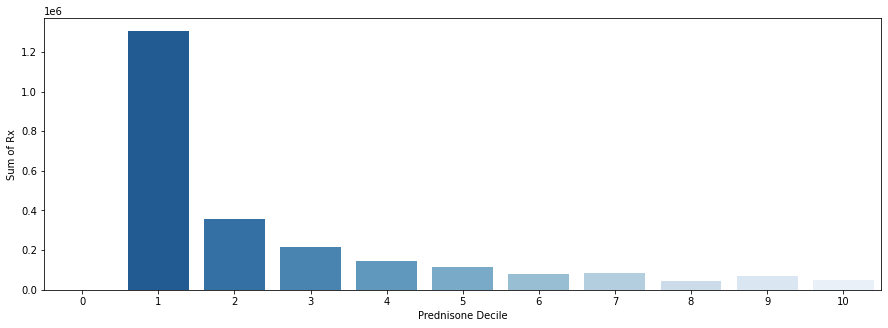

In [67]:
plt.figure(figsize=(15,5))
sns.barplot(x = 'Prednisone Decile' , y = 'Sum of Rx' , data = prednisone_decile_summary , palette="Blues_r")

<AxesSubplot:xlabel='Market Decile', ylabel='Sum of Rx'>

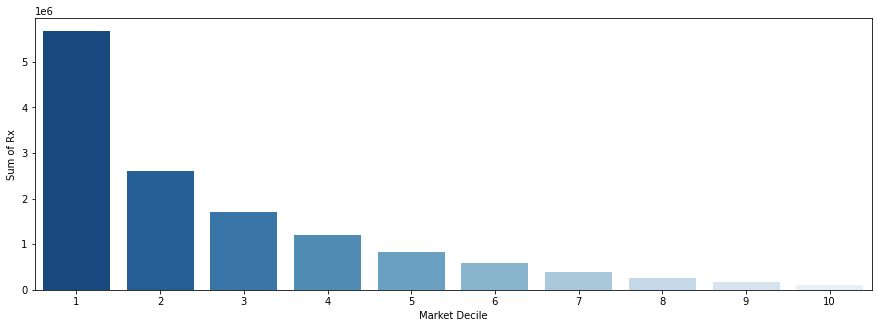

In [66]:
plt.figure(figsize=(15,5))
sns.barplot(x = 'Market Decile' , y = 'Sum of Rx' , data = market_decile_summary , palette='Blues_r')

In [79]:
df_to_save = df_with_deciles[['npi','prednisone_rx','prednisone_decile','market_rx','market_decile']]
#df_to_save.to_csv('HCP data with deciles.CSV',index=False)

In [70]:
df.head()

,cms_prescription_counts,provider_variables,npi,prednisone_rx,market_rx
0,"{'DOXAZOSIN MESYLATE': 26, 'MIDODRINE HCL': 12...","{'settlement_type': 'non-urban', 'generic_rx_c...",1295763035,40,192
1,"{'CEPHALEXIN': 23, 'AMOXICILLIN': 52, 'HYDROCO...","{'settlement_type': 'non-urban', 'generic_rx_c...",1992715205,0,0
2,"{'CEPHALEXIN': 28, 'AMOXICILLIN': 73, 'CLINDAM...","{'settlement_type': 'non-urban', 'generic_rx_c...",1578587630,0,0
3,{'AMOXICILLIN': 63},"{'settlement_type': 'non-urban', 'generic_rx_c...",1932278405,0,0
4,"{'PIOGLITAZONE HCL': 24, 'BENAZEPRIL HCL': 29,...","{'settlement_type': 'non-urban', 'generic_rx_c...",1437366804,0,77


In [75]:
hcp_char_df = pd.DataFrame([row for row in df['provider_variables'].values])
hcp_char_df.head()

,settlement_type,generic_rx_count,specialty,years_practicing,gender,region,brand_name_rx_count
0,non-urban,2287,Nephrology,7,M,South,384
1,non-urban,103,General Practice,7,M,South,0
2,non-urban,112,General Practice,7,M,Midwest,0
3,non-urban,63,General Practice,7,M,South,0
4,non-urban,1035,Nephrology,6,M,West,316


In [76]:
hcp_char_df.shape

(239930, 7)

In [77]:
hcp_char_df['npi'] = df['npi']

In [78]:
hcp_char_df.head()

,settlement_type,generic_rx_count,specialty,years_practicing,gender,region,brand_name_rx_count,npi
0,non-urban,2287,Nephrology,7,M,South,384,1295763035
1,non-urban,103,General Practice,7,M,South,0,1992715205
2,non-urban,112,General Practice,7,M,Midwest,0,1578587630
3,non-urban,63,General Practice,7,M,South,0,1932278405
4,non-urban,1035,Nephrology,6,M,West,316,1437366804


In [80]:
df_to_save = pd.merge(df_to_save , hcp_char_df , on='npi' , how='left')

In [81]:
df_to_save.head()

,npi,prednisone_rx,prednisone_decile,market_rx,market_decile,settlement_type,generic_rx_count,specialty,years_practicing,gender,region,brand_name_rx_count
0,1295763035,40,4,192,3,non-urban,2287,Nephrology,7,M,South,384
1,1437366804,0,0,77,6,non-urban,1035,Nephrology,6,M,West,316
2,1316196462,61,3,318,2,urban,2452,Gastroenterology,5,M,Northeast,374
3,1033483755,57,3,57,6,non-urban,180,Rheumatology,1,F,Northeast,24
4,1518951466,0,0,145,4,non-urban,295,Gastroenterology,8,M,Midwest,121
